In [1]:
from model.Utils import load_data, true, false, impute_data, resample_data, evaluate_model, COLOUR_BLUE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Implement XGBoost Classifier
---
In this notebook, im going to implement XGBoost to see how it performs against random forest.

In [2]:
columns_to_exclude = ['steam_id', 'created_at', 'name', 'total_matches', 'updated_at', 'has_ban', 'rank_premier', 'rank_faceit_elo']

player_data = load_data('data.csv')
imputed_player_data = impute_data(player_data)
X = imputed_player_data.drop(columns=columns_to_exclude)
y = imputed_player_data['has_ban'].map({true: 1, false: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

Loading data from data.csv...
Loaded 423965 players from CSV
Loading imputed data from imputed.csv...
Loaded 423965 players from CSV
Loading resampled data from resampled.csv...
Loaded 567939 resampled samples from CSV
  Banned: 302,269 (53.22%)
  Non-banned: 265,670 (46.78%)


## Train Model
---
Training XGBoost classifier with default parameters.

Evaluating model...


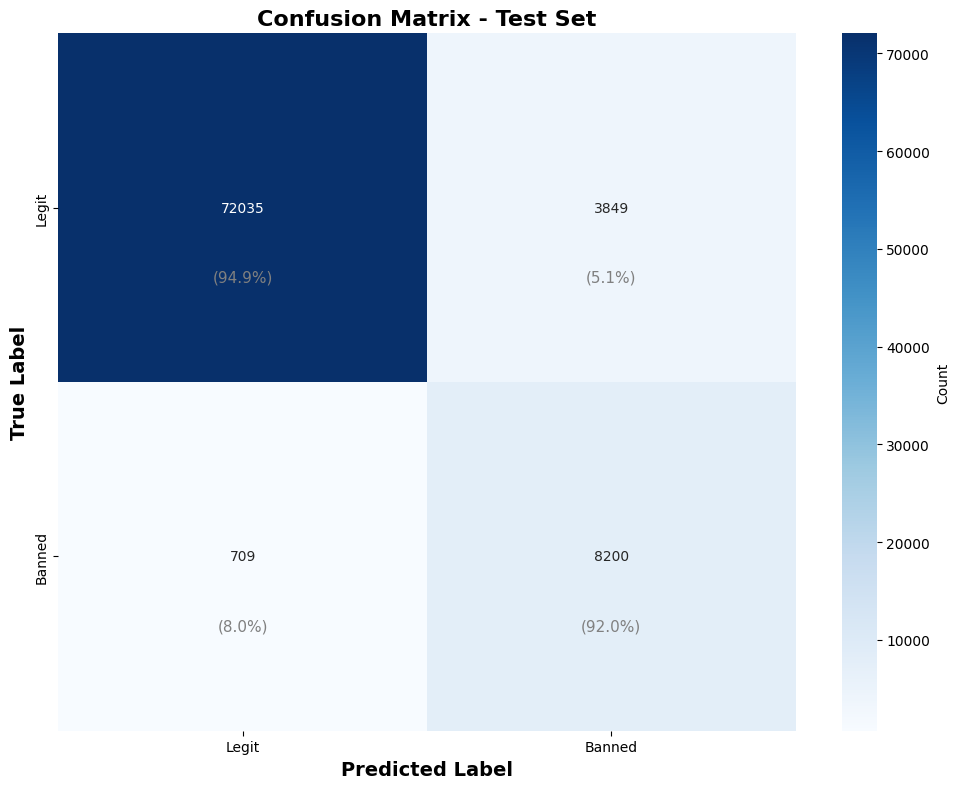

Metrics:
  ROC-AUC Score:           0.9773
  Precision (Banned):      0.6806
  Recall (Banned):         0.9204
  F1-Score (Banned):       0.7825
  False Positive Rate:     0.0507 (3,849 legit players incorrectly flagged)
  False Negative Rate:     0.0796 (709 cheaters missed)
  True Positives:          8,200 cheaters correctly identified
  True Negatives:          72,035 legit players correctly identified


In [3]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_resampled, y_train_resampled)
metrics = evaluate_model(xgb_clf, X_test, y_test, show_plot=True)

## Comparison: XGBoost vs Random Forest
---
Let's train a Random Forest model with the same data to compare performance.

Evaluating model...


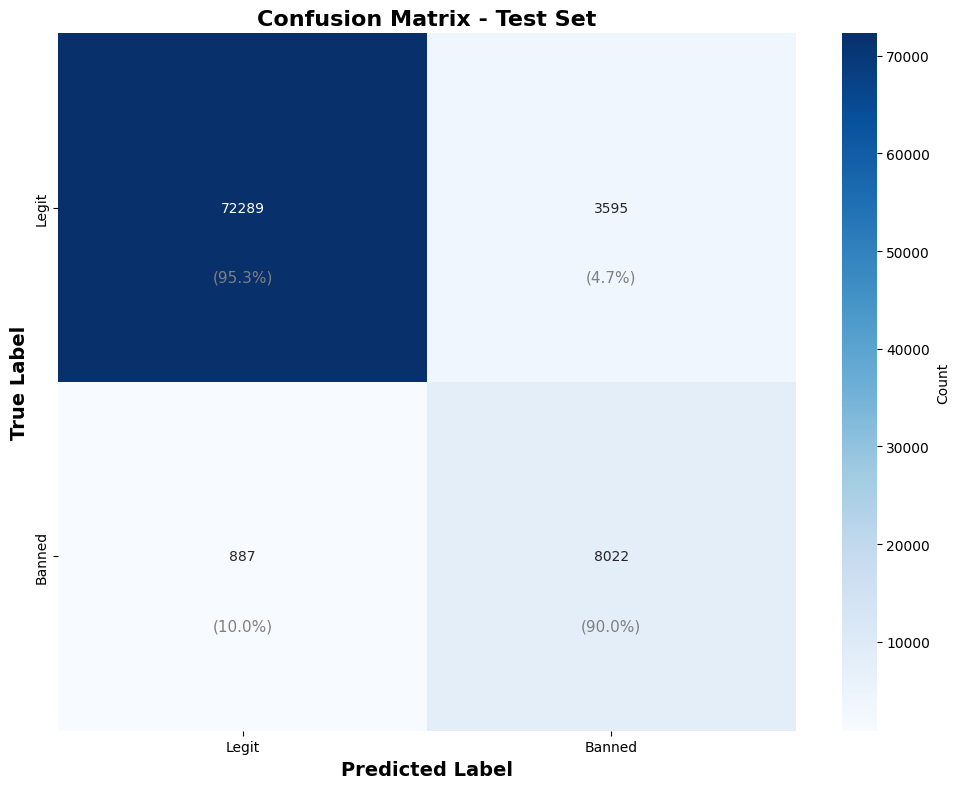

Metrics:
  ROC-AUC Score:           0.9753
  Precision (Banned):      0.6905
  Recall (Banned):         0.9004
  F1-Score (Banned):       0.7816
  False Positive Rate:     0.0474 (3,595 legit players incorrectly flagged)
  False Negative Rate:     0.0996 (887 cheaters missed)
  True Positives:          8,022 cheaters correctly identified
  True Negatives:          72,289 legit players correctly identified


In [4]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_resampled, y_train_resampled)
rf_metrics = evaluate_model(rf_clf, X_test, y_test, show_plot=True)

# Results
---
XGBoost seemed to catch a higher percentage of cheaters but flagged a few more legit players. I think this compromise is worth it and will now implement grid search to try and improve performance further.

# GridSearchCV
---
Now we'll use GridSearchCV to find the optimal hyperparameters for XGBoost, optimizing for F1 score.

In [7]:
param_grid = {
    'max_depth': [10, 15, 20],
    'learning_rate': [0.3, 0.5, 0.7]
}

xgb_base = xgb.XGBClassifier(
    random_state=42,
    n_jobs=4,
    eval_metric='logloss'
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=2,
    return_train_score=True
)

grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.3, 0.5, ...], 'max_depth': [10, 15, ...]}"
,scoring,'f1'
,n_jobs,2
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,objective,'binary:logistic'


In [19]:
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

best_xgb_model = grid_search.best_estimator_

  learning_rate: 0.5
  max_depth: 15

Best Cross-Validation F1 Score: 0.9849


## Evaluate Best Model
---
Now let's evaluate the best model found by GridSearchCV on the test set.

Evaluating model...


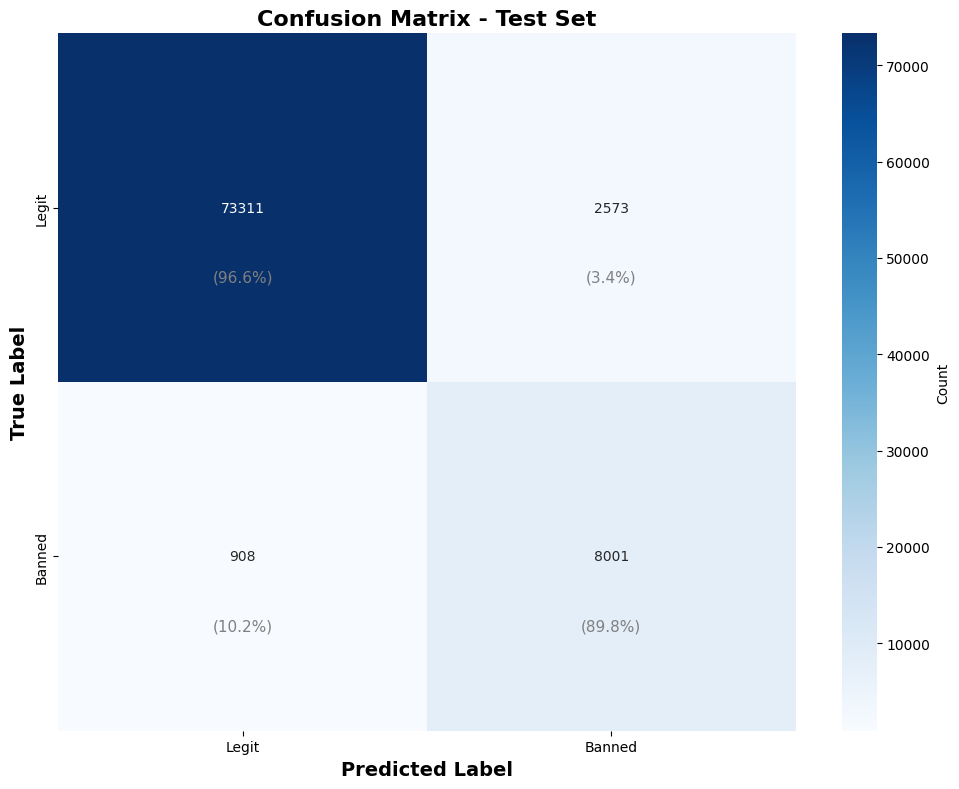

Metrics:
  ROC-AUC Score:           0.9774
  Precision (Banned):      0.7567
  Recall (Banned):         0.8981
  F1-Score (Banned):       0.8213
  False Positive Rate:     0.0339 (2,573 legit players incorrectly flagged)
  False Negative Rate:     0.1019 (908 cheaters missed)
  True Positives:          8,001 cheaters correctly identified
  True Negatives:          73,311 legit players correctly identified
Baseline XGBoost F1 Score: 0.7825
Optimized XGBoost F1 Score: 0.8213
Improvement: 4.96%


In [18]:
best_metrics = evaluate_model(best_xgb_model, X_test, y_test)

print(f"Original XGBoost F1 Score: {metrics['f1_score']:.4f}")
print(f"Optimized XGBoost F1 Score: {best_metrics['f1_score']:.4f}")
print(f"Improvement: {((best_metrics['f1_score'] / metrics['f1_score']) - 1) * 100:.2f}%")